# Named Entity Recognition with PyTorch

In this notebook we'll explore how we can use Deep Learning for sequence labelling tasks such as part-of-speech tagging or named entity recognition. We won't focus on getting state-of-the-art accuracy, but rather, implement a first neural network to get the main concepts across.

## Data

For our experiments we'll reuse the NER data we've already used for our CRF experiments. The Dutch CoNLL-2002 data has four kinds of named entities (people, locations, organizations and miscellaneous entities) and comes split into a training, development and test set. 

In [1]:
import nltk

train_sents = list(nltk.corpus.conll2002.iob_sents('ned.train'))
dev_sents = list(nltk.corpus.conll2002.iob_sents('ned.testa'))
test_sents = list(nltk.corpus.conll2002.iob_sents('ned.testb'))

train_sents[:3]

[[('De', 'Art', 'O'),
  ('tekst', 'N', 'O'),
  ('van', 'Prep', 'O'),
  ('het', 'Art', 'O'),
  ('arrest', 'N', 'O'),
  ('is', 'V', 'O'),
  ('nog', 'Adv', 'O'),
  ('niet', 'Adv', 'O'),
  ('schriftelijk', 'Adj', 'O'),
  ('beschikbaar', 'Adj', 'O'),
  ('maar', 'Conj', 'O'),
  ('het', 'Art', 'O'),
  ('bericht', 'N', 'O'),
  ('werd', 'V', 'O'),
  ('alvast', 'Adv', 'O'),
  ('bekendgemaakt', 'V', 'O'),
  ('door', 'Prep', 'O'),
  ('een', 'Art', 'O'),
  ('communicatiebureau', 'N', 'O'),
  ('dat', 'Conj', 'O'),
  ('Floralux', 'N', 'B-ORG'),
  ('inhuurde', 'V', 'O'),
  ('.', 'Punc', 'O')],
 [('In', 'Prep', 'O'),
  ("'81", 'Num', 'O'),
  ('regulariseert', 'V', 'O'),
  ('de', 'Art', 'O'),
  ('toenmalige', 'Adj', 'O'),
  ('Vlaamse', 'Adj', 'B-MISC'),
  ('regering', 'N', 'O'),
  ('de', 'Art', 'O'),
  ('toestand', 'N', 'O'),
  ('met', 'Prep', 'O'),
  ('een', 'Art', 'O'),
  ('BPA', 'N', 'B-MISC'),
  ('dat', 'Pron', 'O'),
  ('het', 'Art', 'O'),
  ('bedrijf', 'N', 'O'),
  ('op', 'Prep', 'O'),
  ('eigen', 

Next, we're going to preprocess the data. For this we use the `torchtext` Python library, which has a number of handy  utilities for preprocessing natural language. We process our data to a Dataset that consists of Examples. Each of these examples has two fields: a text field and a label field. Both contain sequential information (the sequence of tokens, and the sequence of labels). We don't have to tokenize this information anymore, as the CONLL data has already been tokenized for us.

In [2]:
from torchtext.data import Example
from torchtext.data import Field, Dataset

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

def read_data(sentences):
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for sentence in sentences: 
        tokens = [t[0] for t in sentence]
        labels = [t[2] for t in sentence]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])

train_data = read_data(train_sents)
dev_data = read_data(dev_sents)
test_data = read_data(test_sents)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(dev_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x105d86b30>, 'text': <torchtext.data.field.Field object at 0x105d87160>}
['De', 'tekst', 'van', 'het', 'arrest', 'is', 'nog', 'niet', 'schriftelijk', 'beschikbaar', 'maar', 'het', 'bericht', 'werd', 'alvast', 'bekendgemaakt', 'door', 'een', 'communicatiebureau', 'dat', 'Floralux', 'inhuurde', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']
Train: 15806
Dev: 2895
Test: 5195


Next, we build a vocabulary for both fields. This vocabulary allows us to map every word and label to their index. One index is kept for unknown words, another one for padding.

In [3]:
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

## Training

If we're on a machine with a CUDA-enabled GPU, we'd like to use this GPU for training and testing. If not, we'll just use the CPU. The check below allows us to write code that works on both CPU and GPU.

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Another convenient class in `Torchtext` is the BucketIterator. This iterator creates batches of similar-length examples in the data. It also takes care of mapping the words and labels to the correct indices in their vocabularies, and pads the sentences so that they all have the same length. The Bucketiterator creates batches of similar-length examples to minimize the amount of padding. 

In [5]:
from torchtext.data import BucketIterator

BATCH_SIZE = 32
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
dev_iter = BucketIterator(dataset=dev_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

## Pre-trained embeddings

Pre-trained embeddings embeddings are generally an easy way of improving the performance of your model, particularly if you have little training data. Thanks to these embeddings, you'll be able to make use of knowledge about the meaning and use of the words in your dataset that was learned from another, typically larger data set. In this way, your model will be able to generalize better between semantically related words. 

In this example, we make use of the popular FastText embeddings. These are high-quality pre-trained word embeddings that are available for a wide variety of languages. After downloading the `vec` file with the embeddings, we use them to initialize our embedding matrix. We do this by creating a matrix filled with zeros whose number of rows equals the number of words in our vocabulary and whose number of columns equals the number of dimensions in the FastText vectors (300). We have to take care that we insert the FastText embedding for a particular word in the correct row. This is the row whose index corresponds to the index of the word in the vocabulary. 

In [6]:
import random
import os
import numpy as np

EMBEDDING_PATH = "/Users/antoineedy/Documents/MSc AI/Semester 2/NLP/Coursework/code/data/cc.nl.300.vec"


def load_embeddings(path):
    """ Load the FastText embeddings from the embedding file. """
    print("Loading pre-trained embeddings")
    
    embeddings = {}
    with open(path) as i:
        for line in i:
            if len(line) > 2: 
                line = line.strip().split()
                word = line[0]
                embedding = np.array(line[1:])
                embeddings[word] = embedding
    
    return embeddings
    

def initialize_embeddings(embeddings, vocabulary):
    """ Use the pre-trained embeddings to initialize an embedding matrix. """
    print("Initializing embedding matrix")
    embedding_size = len(embeddings["."])
    embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                
    for idx, word in enumerate(vocabulary.itos): 
        if word in embeddings:
            embedding_matrix[idx,:] = embeddings[word]
            
    return embedding_matrix

embeddings = load_embeddings(EMBEDDING_PATH)
embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
embedding_matrix = torch.from_numpy(embedding_matrix).to(device)

Loading pre-trained embeddings
Initializing embedding matrix


## Model

Next, we create our BiLSTM model. It consists of four layers:
    
- An embedding layer that maps one-hot word vectors to dense word embeddings. These embeddings are either pretrained or trained from scratch.
- A bidirectional LSTM layer that reads the text both front to back and back to front. For each word, this LSTM produces two output vectors of dimensionality `hidden_dim`, which are concatenated to a vector of `2*hidden_dim`.
- A dropout layer that helps us avoid overfitting by dropping a certain percentage of the items in the LSTM output.
- A dense layer that projects the LSTM output to an output vector with a dimensionality equal to the number of labels.

We initialize these layers in the `__init__` method, and put them together in the `forward` method.

In [7]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

## Training

Then we need to train this model. This involves taking a number of decisions: 

- We pick a loss function (or `criterion`) to quantify how far away the model predictions are from the correct output. For multiclass tasks such as Named Entity Recognition, a standard loss function is the Cross-Entropy Loss, which here measures the difference between two multinomial probability distributions. PyTorch's `CrossEntropyLoss` does this by first applying a `softmax` to the last layer of the model to transform the output scores to probabilities, and then computing the cross-entropy between the predicted and correct probability distributions. The `ignore_index` parameter allows us to mask the padding items in the training data, so that these do not contribute to the loss. We also remove these masked items from the output afterwards, so they are not taken into account when we evaluate the model output.
- Next, we need to choose an optimizer. For many NLP problems, the Adam optimizer is a good first choice. Adam is a variation of Stochastic Gradient Descent with several advantages: it maintains per-parameter learning rates and adapts these learning rates based on how quickly the values of a specific parameter are changing (or, how large its average gradient is).

Then the actual training starts. This happens in several epochs. During each epoch, we show all of the training data to the network, in the batches produced by the BucketIterators we created above. Before we show the model a new batch, we set the gradients of the model to zero to avoid accumulating gradients across batches. Then we let the model make its predictions for the batch. We do this by taking the output, and finding out what label received the highest score, using the `torch.max` method. We then compute the loss with respect to the correct labels. `loss.backward()` then computes the gradients for all model parameters; `optimizer.step()` performs an optimization step.

When we have shown all the training data in an epoch, we perform the precision, recall and F-score on the training data and development data. Note that we compute the loss for the development data, but we do not optimize the model with it. Whenever the F-score on the development data is better than before, we save the model. If the F-score is lower than the minimum F-score we've seen in the past few epochs (we call this number the patience), we stop training.

In [8]:
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import precision_recall_fscore_support, classification_report


def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask


def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    criterion = nn.CrossEntropyLoss(ignore_index=1)  # we mask the <pad> labels
    optimizer = optim.Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)
        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)
        
        dev_f = dev_scores[2]
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Development F-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

When we test the model, we basically take the same steps as in the evaluation on the development data above: we get the predictions, remove the masked items and print a classification report. 

In [9]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                               correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

Now we can start the actual training. We set the embedding dimension to 300 (the dimensionality of the FastText embeddings), and pick a hidden dimensionality for each component of the BiLSTM (which will therefore output 512-dimensional vectors). The number of classes (the length of the vocabulary of the label field) will become the dimensionality of the output layer. Finally, we also compute the number of batches in an epoch, so that we can show a progress bar.

In [14]:
print(f"classes : {label_field.vocab.itos}")

classes : ['<unk>', '<pad>', 'O', 'B-PER', 'B-MISC', 'B-LOC', 'I-PER', 'B-ORG', 'I-MISC', 'I-ORG', 'I-LOC']


In [10]:
import math

EMBEDDING_DIM = 300
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
print(NUM_CLASSES)
MAX_EPOCHS = 50
PATIENCE = 3
OUTPUT_PATH = "/tmp/bilstmtagger"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  

train_f, dev_f = train(tagger.to(device), train_iter, dev_iter, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 0:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 218.5476920902729
Training performance: (0.9242563313002112, 0.9242563313002112, 0.9242563313002112, None)
Total development loss: 25.24868930131197
Development performance: (0.9279327088916602, 0.9279327088916602, 0.9279327088916602, None)
Saving model.


/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 1:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 72.36405092664063
Training performance: (0.958863820295691, 0.958863820295691, 0.958863820295691, None)
Total development loss: 19.92100143060088
Development performance: (0.9373789370339906, 0.9373789370339906, 0.9373789370339906, None)
Saving model.


/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 2:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 51.41974694933742
Training performance: (0.9682744122697934, 0.9682744122697934, 0.9682744122697934, None)
Total development loss: 17.177124603185803
Development performance: (0.9426062037307295, 0.9426062037307295, 0.9426062037307295, None)
Saving model.


/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 3:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 41.59789576870389
Training performance: (0.9727305027535974, 0.9727305027535974, 0.9727305027535974, None)
Total development loss: 18.22673653624952
Development performance: (0.9428715472178736, 0.9428715472178736, 0.9428715472178736, None)
Saving model.


/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 4:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 35.33896045514848
Training performance: (0.9758344683286947, 0.9758344683286947, 0.9758344683286947, None)
Total development loss: 15.655755868647248
Development performance: (0.9466659590840343, 0.9466659590840343, 0.9466659590840343, None)
Saving model.


/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 5:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 30.9835976526374
Training performance: (0.9784400228972977, 0.9784400228972977, 0.9784400228972977, None)
Total development loss: 15.495041329297237
Development performance: (0.9459495316687452, 0.9459495316687452, 0.9459495316687452, None)


/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 6:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 27.42213863239158
Training performance: (0.9803102978622609, 0.9803102978622609, 0.9803102978622609, None)
Total development loss: 17.537605117075145
Development performance: (0.9462679438533181, 0.9462679438533181, 0.9462679438533181, None)


/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 7:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 25.07533115631668
Training performance: (0.981425554173822, 0.981425554173822, 0.981425554173822, None)
Total development loss: 15.583940194337629
Development performance: (0.9468251651763208, 0.9468251651763208, 0.9468251651763208, None)
Saving model.


/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 8:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 22.29050536567229
Training performance: (0.9834586762993229, 0.9834586762993229, 0.9834586762993229, None)
Total development loss: 15.163805407413747
Development performance: (0.9495316687451907, 0.9495316687451907, 0.9495316687451907, None)
Saving model.


/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 9:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 19.994789334392408
Training performance: (0.9845986064230868, 0.9845986064230868, 0.9845986064230868, None)
Total development loss: 15.101379131505382
Development performance: (0.9490540504683312, 0.9490540504683312, 0.9490540504683312, None)


/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 10:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 18.557677717879415
Training performance: (0.9853338860267267, 0.9853338860267267, 0.9853338860267267, None)
Total development loss: 15.015267799957655
Development performance: (0.9495051343964762, 0.9495051343964762, 0.9495051343964762, None)


/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 11:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 16.472296853462467
Training performance: (0.986735358559839, 0.986735358559839, 0.986735358559839, None)
Total development loss: 16.73202333971858
Development performance: (0.9492132565606177, 0.9492132565606177, 0.9492132565606177, None)


/var/folders/ps/_pncn3k9245b7khb5ymg3smw0000gn/T/ipykernel_31784/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 12:   0%|          | 0/494 [00:00<?, ?it/s]

Total training loss: 14.967446597060189
Training performance: (0.9876877677108624, 0.9876877677108624, 0.9876877677108624, None)
Total development loss: 18.059295641083736
Development performance: (0.9491336535144745, 0.9491336535144745, 0.9491336535144745, None)
Development F-score does not improve anymore. Stop training.


Let's now plot the evolution of the F-score on our training and development set, to visually evaluate if training went well. If it did, the training F-score should first increase suddenly, then more gradually. The development F-score will increase during the first few epochs, but at some point it will start to decrease again. That's when the model starts overfitting. This is where we abandon training, and why we only save the model when we have reached an optimal F-score on the development data.

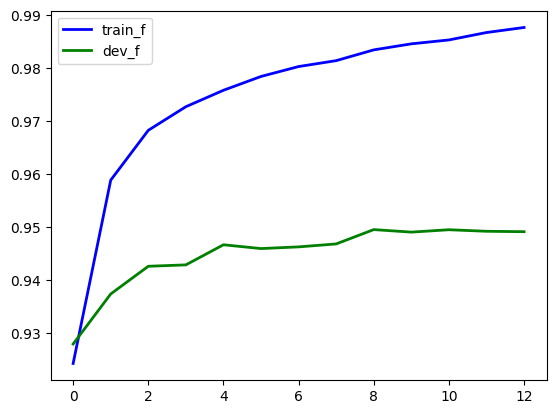

In [11]:
%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f': train_f, 
                   'dev_f': dev_f})
 
# multiple line plot
plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'dev_f', data=df, color='green', linewidth=2)
plt.legend()
plt.show()


Before we test our model on the test data, we have to run its `eval()` method. This will put the model in eval mode, and deactivate dropout layers and other functionality that is only useful in training.

In [12]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(20002, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=11, bias=True)
)

Finally, we test the model. You'll notice its performance is significantly lower than that of the CRF we explored in an earlier notebook. Designing a competitive neural network takes considerably more effort than we put in here: you'll need to make the architecture of the network more complex, optimize its hyperparameters, and often also throw considerably more data at your model.

In [17]:
labels = label_field.vocab.itos[3:]
print(labels)
print(label_field.vocab.itos)
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]

test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)

['B-PER', 'B-MISC', 'B-LOC', 'I-PER', 'B-ORG', 'I-MISC', 'I-ORG', 'I-LOC']
['<unk>', '<pad>', 'O', 'B-PER', 'B-MISC', 'B-LOC', 'I-PER', 'B-ORG', 'I-MISC', 'I-ORG', 'I-LOC']
              precision    recall  f1-score   support

       B-LOC       0.86      0.64      0.74       774
       I-LOC       0.39      0.43      0.41        49
      B-MISC       0.84      0.48      0.61      1187
      I-MISC       0.58      0.30      0.39       410
       B-ORG       0.84      0.51      0.63       882
       I-ORG       0.80      0.52      0.63       551
       B-PER       0.88      0.66      0.76      1098
       I-PER       0.96      0.71      0.82       807

   micro avg       0.85      0.57      0.68      5758
   macro avg       0.77      0.53      0.62      5758
weighted avg       0.84      0.57      0.67      5758



# Conclusion

In this notebook we've trained a simple bidirectional LSTM for named entity recognition. Far from achieving state-of-the-art performance, our aim was to understand how neural networks can be implemented and trained in PyTorch. To improve our performance, one of the things that is typically done is to add an additional CRF layer to the neural network. This layer helps us optimize the complete label sequence, and not the labels individually. We leave that for future work. 